In [16]:
import pandas as pd

df = pd.read_csv("AA.Complete Data.csv")
df = df.drop(columns = ["MW Demand"])
df["DATE & TIME"] = pd.to_datetime(df["DATE & TIME"])
df.head()
print(df.columns)

Index(['DATE & TIME', 'Solar Radiation (Wh/m)2', 'UV Intensity',
       'Atmospheric Clarity', 'Temperature (2m)', 'Humidity (2M)', 'PS',
       'Wind Speed (10m)', 'Wind Direction (10m)', 'MW Supply'],
      dtype='object')


## Create Lag Features <br>
As decision trees can not understand time real data, I need to explicit tell it past values by creating new features with past data <br>
I am creating 24 lags per feature so the tree can "look back" at the past 24 hours of data


In [17]:
def create_lag_features(data, columns, lags=3):
    lagged_dfs = []  # list to store lagged DataFrames

    for column in columns:
        for lag in range(1, lags + 1):
            lagged_col = data[column].shift(lag)
            lagged_col.name = f"{column}_lag{lag}"
            lagged_dfs.append(lagged_col)

    # Combine all lagged columns into one DataFrame
    # Helps prevent issues with pandas performance
    lagged_features = pd.concat(lagged_dfs, axis=1)

    # Combine with original data and drop NaNs caused by shifting
    data = pd.concat([data, lagged_features], axis=1).dropna()

    return data

# Specify the columns to generate lags for (not including DATE & TIME)
columns_to_lag = ['Solar Radiation (Wh/m)2', 'UV Intensity', 'Atmospheric Clarity',
                  'Temperature (2m)', 'Humidity (2M)', 'PS', 'Wind Speed (10m)',
                  'Wind Direction (10m)']

# Create lag features for the past 24 hours
df_lagged = create_lag_features(df, columns=columns_to_lag, lags=3)

# Now I can prepare the data for training
X = df_lagged.drop(['DATE & TIME', 'MW Supply'], axis=1)  # Drop 'DATE & TIME' and target variable 'MW Supply'
y = df_lagged['MW Supply']  # Target variable (MW Supply)


## Chronological Splitting The Data

In [18]:
n = len(X)

# 80% of the data for training
train_end = int(n * 0.8)

# 10% of the data for validation (next 10%)
val_end = int(n * 0.9)

# Training set: first 80%
X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]

# Validation set: next 10%
X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]

# Test set: final 10%
X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]

## Create Decision Tree

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=42)

# Define parameter grid
param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1  # Use all processors
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best parameters:", grid_search.best_params_)
print("Best MAE:", -grid_search.best_score_)

# Get the best model from the grid search
model = grid_search.best_estimator_

# Fit it again on the full training data
model.fit(X_train, y_train)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best MAE: 19.265027954999454


DecisionTreeRegressor(max_depth=5, min_samples_leaf=4, random_state=42)

## Calculate The Accuracy

In [20]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Predict on all sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_val_pred = model.predict(X_val)

# Calculate MAE
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)

# Calculate mean of true values
mean_train = np.mean(y_train)
mean_test = np.mean(y_test)
mean_val = np.mean(y_val)

# Calculate RMAE
rmae_train = mae_train / mean_train
rmae_test = mae_test / mean_test
rmae_val = mae_val / mean_val

# Print results
print(f"Training RMAE: {rmae_train * 100:.2f}%")
print(f"Validation RMAE: {rmae_val * 100:.2f}%")
print(f"Testing RMAE: {rmae_test * 100:.2f}%")

Training RMAE: 14.43%
Testing RMAE: 22.52%
Validation RMAE: 21.66%


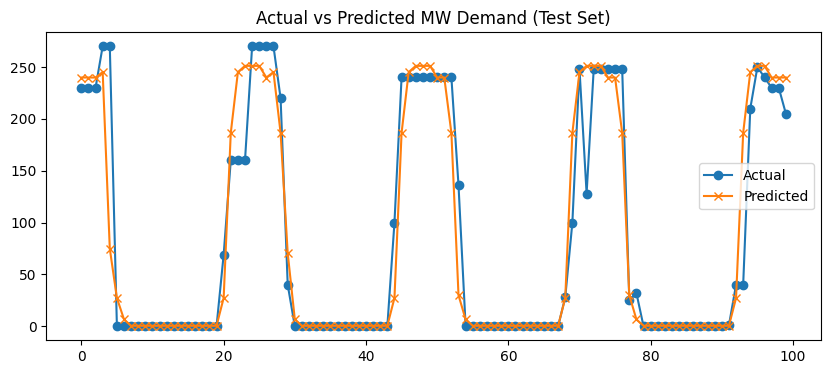

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_test_pred[:100], label='Predicted', marker='x')
plt.legend()
plt.title("Actual vs Predicted MW Demand (Test Set)")
plt.show()
